In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

import warnings
warnings.filterwarnings("ignore")



In [ ]:
base_dir = "/kaggle/input/brain-tumor-mri-dataset"

train_path = os.path.join(base_dir, "Training")
test_path = os.path.join(base_dir, "Testing")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

I0000 00:00:1744986803.821760      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint('resnet50_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/25


I0000 00:00:1744986897.968752     117 service.cc:148] XLA service 0x7c410c005ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744986897.969461     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744986899.796920     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.2500 - loss: 1.5873   

I0000 00:00:1744986906.565673     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 133s 589ms/step - accuracy: 0.5026 - loss: 1.1030 - val_accuracy: 0.3440 - val_loss: 1.1871 - learning_rate: 1.0000e-05
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 367ms/step - accuracy: 0.6738 - loss: 0.7986 - val_accuracy: 0.6537 - val_loss: 0.8329 - learning_rate: 1.0000e-05
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.7124 - loss: 0.7148 - val_accuracy: 0.7063 - val_loss: 0.7582 - learning_rate: 1.0000e-05
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.7261 - loss: 0.6855 - val_accuracy: 0.6773 - val_loss: 0.7983 - learning_rate: 1.0000e-05
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 360ms/step - accuracy: 0.7410 - loss: 0.6467 - val_accuracy: 0.6217 - val_loss: 0.9165 - learning_rate: 1.0000e-05
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 364ms/step - accuracy: 0.7383 - loss: 0.6458 - val_accuracy: 0.7162 - val_loss: 0.6650 - learning_rate: 1.0000e-05
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 357ms/step -

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7436 - loss: 0.6024
Test Accuracy: 76.58%


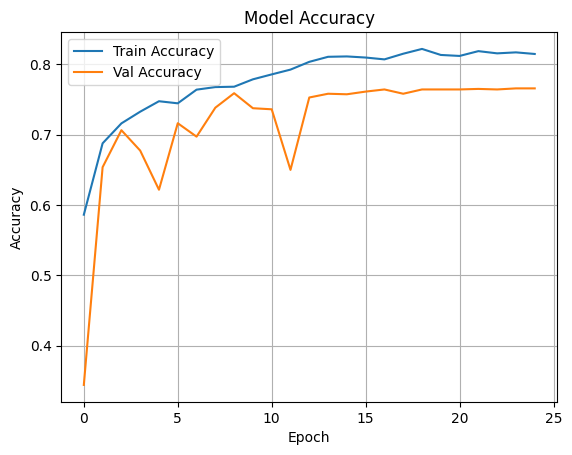

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint('vgg16_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights = dict(enumerate(class_weights))


In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[checkpoint, reduce_lr, early_stop],
    class_weight=class_weights
)

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - accuracy: 0.4283 - loss: 1.2358 - val_accuracy: 0.7368 - val_loss: 0.6720 - learning_rate: 1.0000e-05
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.7833 - loss: 0.6218 - val_accuracy: 0.8108 - val_loss: 0.5349 - learning_rate: 1.0000e-05
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 364ms/step - accuracy: 0.8331 - loss: 0.4775 - val_accuracy: 0.8421 - val_loss: 0.4600 - learning_rate: 1.0000e-05
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 360ms/step - accuracy: 0.8670 - loss: 0.4078 - val_accuracy: 0.8345 - val_loss: 0.4787 - learning_rate: 1.0000e-05
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 362ms/step - accuracy: 0.8676 - loss: 0.3827 - val_accuracy: 0.8337 - val_loss: 0.4554 - learning_rate: 1.0000e-05
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 364ms/step - accuracy: 0.8742 - loss: 0.3556 - val_accuracy: 0.8482 - val_loss: 0.4172 - learning_rate: 1.0000e-05
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 36

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9284 - loss: 0.2160
Test Accuracy: 91.38%


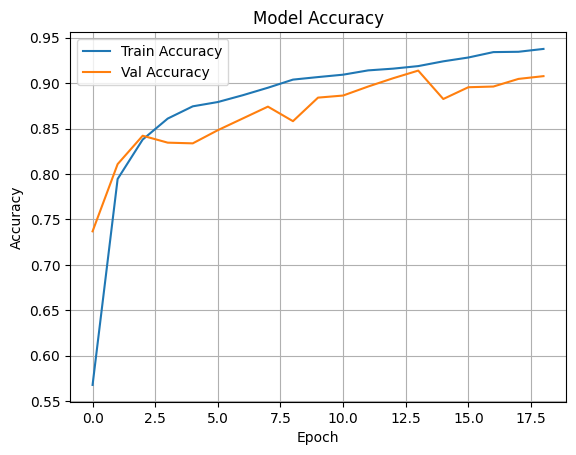

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save('/kaggle/working/vgg16_best_model.keras')


In [ ]:
model.save_weights('/kaggle/working/vgg16_weights.weights.h5')


In [ ]:
%cd /kaggle/working


from IPython.display import FileLink
FileLink('vgg16_best_model.keras')


/kaggle/working


/kaggle/working/vgg16_best_model.keras

In [ ]:
%cd /kaggle/working


from IPython.display import FileLink
FileLink('vgg16_weights.weights.h5')


/kaggle/working


/kaggle/working/vgg16_weights.weights.h5

## Fine_Tuned VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


I0000 00:00:1745274556.353219      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = models.Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint('vgg16_final_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/30


I0000 00:00:1745274820.642193     142 service.cc:148] XLA service 0x7c03f00077b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745274820.642932     142 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745274821.255011     142 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/179 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.2812 - loss: 2.0471 

I0000 00:00:1745274831.166628     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6034 - loss: 0.9665
Epoch 1: val_accuracy improved from -inf to 0.85584, saving model to vgg16_final_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 541ms/step - accuracy: 0.6041 - loss: 0.9651 - val_accuracy: 0.8558 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8428 - loss: 0.4429
Epoch 2: val_accuracy improved from 0.85584 to 0.85812, saving model to vgg16_final_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 384ms/step - accuracy: 0.8429 - loss: 0.4427 - val_accuracy: 0.8581 - val_loss: 0.3578 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8751 - loss: 0.3590
Epoch 3: val_accuracy did not improve from 0.85812
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 362ms/step - accuracy: 0.8752 - loss: 0.3588 - val_accuracy: 0.8032 - val_loss: 0.5699 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accura

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9510 - loss: 0.1309
Test Accuracy: 96.19%


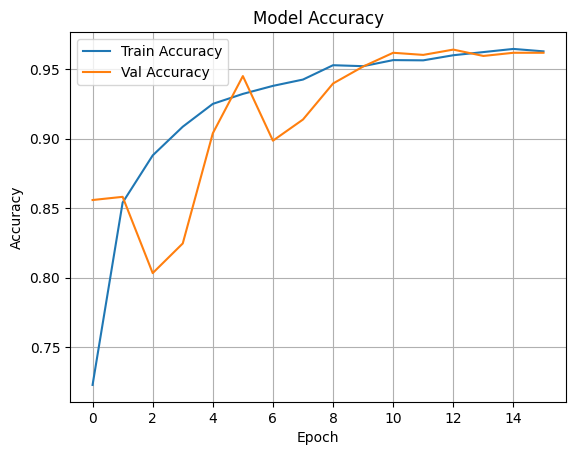

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save('/kaggle/working/vgg16_final_model.keras')


In [ ]:
model.save_weights('/kaggle/working/vgg16_final_weights.weights.h5')


In [ ]:
%cd /kaggle/working


from IPython.display import FileLink
FileLink('vgg16_final_model.keras')


/kaggle/working


/kaggle/working/vgg16_final_model.keras

In [ ]:
%cd /kaggle/working


from IPython.display import FileLink
FileLink('vgg16_final_weights.weights.h5')

/kaggle/working


/kaggle/working/vgg16_final_weights.weights.h5